# Image Tracking by using Interest Points

In [57]:
# Required Libraries
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time

### Loading and displaying a Video File

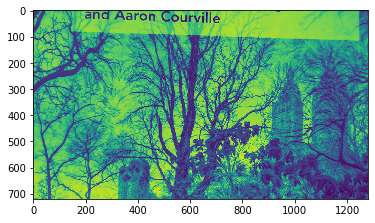

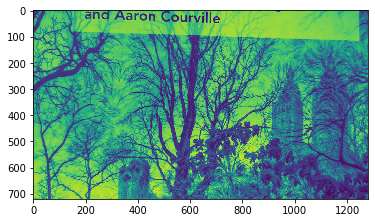

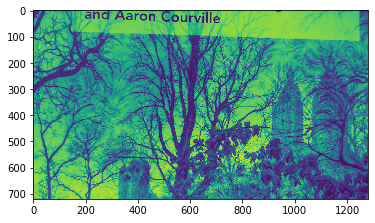

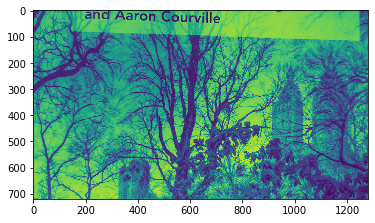

End of video
Total Frames: 4


In [2]:
video_name = 'vid_01.mp4'
cap = cv2.VideoCapture('VIDEO/' + video_name)
numOfFrames = 4
frameCount = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False or frameCount == numOfFrames:
        print("End of video")
        break;

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    plt.imshow(gray)
    plt.show()
    
    frameCount+=1

cap.release()
print("Total Frames: " + str(frameCount))

## Preconfiguration

What we are going to do first is to change the figure size for the Matplotlib plot.

In [3]:
plt.rcParams['figure.dpi'] = 150

Then, lets load the image that will be used to test the different feature detectors algorithms.

In [4]:
img_ref_name = 'IMG/deep_learning_book.jpg'
img_eval_name = 'IMG/test_3.jpg'

# load the image and convert it to grayscale
img_ref = cv2.imread(img_ref_name)
img_eval = cv2.imread(img_eval_name)
gray_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)
gray_eval = cv2.cvtColor(img_eval, cv2.COLOR_BGR2GRAY)

## General Keypoints Function

In [64]:
def get_keypoints(gray1, gray2, detector):    
    
    # detect keypoints and extract local invariant descriptors from the img
    start = time.time()
    (kps1, descs1) = detector.detectAndCompute(gray1, None)
    (kps2, descs2) = detector.detectAndCompute(gray2, None)
    end = time.time()

    print("keypoints: {}, descriptors: {}".format(len(kps1), descs1.shape))
    print("keypoints: {}, descriptors: {}".format(len(kps2), descs2.shape))
    print("keypoints detection time: {:0.2f} seconds".format(end - start))

    img_ref = cv2.drawKeypoints(gray1, kps1, None)
    img_eval = cv2.drawKeypoints(gray2, kps2, None)
    
    return (img_ref, img_eval, kps1, descs1, kps2, descs2)

## SIFT (Scale-Invariant Feature Transform )

In [65]:
# initialize the SIFT descriptor
sift_detector = cv2.xfeatures2d.SIFT_create()

# get the keypoints
(img_ref_sift, img_eval_sift, kps1_sift, descs1_sift, kps2_sift, descs2_sift) = get_keypoints(gray_ref,
                                                                                              gray_eval,
                                                                                              sift_detector)

keypoints: 4898, descriptors: (4898, 128)
keypoints: 682, descriptors: (682, 128)
keypoints detection time: 0.29 seconds


## SURF (Speeded-Up Robust Features)

In [66]:
# initialize the SURF descriptor
surf_detector = cv2.xfeatures2d.SURF_create()

# get the keypoints
(img_ref_surf, img_eval_surf, kps1_surf, descs1_surf, kps2_surf, descs2_surf) = get_keypoints(gray_ref,
                                                                                              gray_eval,
                                                                                              surf_detector)

keypoints: 2572, descriptors: (2572, 64)
keypoints: 1349, descriptors: (1349, 64)
keypoints detection time: 0.35 seconds


## ORB (Oriented FAST and Rotated BRIEF)

__BRIEF__ (Binary Robust Independent Elementary Features) is a feature descriptor and it doesn't provide any method to find the features by itself.

In [67]:
# initialize the ORB descriptor
orb_detector = cv2.ORB_create(nfeatures = 4000)

# get the keypoints
(img_ref_orb, img_eval_orb, kps1_orb, descs1_orb, kps2_orb, descs2_orb) = get_keypoints(gray_ref,
                                                                                        gray_eval,
                                                                                        orb_detector)

keypoints: 3869, descriptors: (3869, 32)
keypoints: 1865, descriptors: (1865, 32)
keypoints detection time: 0.05 seconds


## BRISK (Binary Robust Invariant Scalable Keypoints)

In [68]:
# initialize the ORB descriptor
brisk_detector = cv2.BRISK_create()

# get the keypoints
(img_ref_brisk, img_eval_brisk, kps1_brisk, descs1_brisk, kps2_brisk, descs2_brisk) = get_keypoints(gray_ref,
                                                                                                    gray_eval,
                                                                                                    brisk_detector)

keypoints: 8135, descriptors: (8135, 64)
keypoints: 447, descriptors: (447, 64)
keypoints detection time: 0.21 seconds


## Brute Force Matcher

In [33]:
def getBFMatcher(ref_img, kp1, desc1, eval_img, kp2, desc2, threshold):

    # Match the features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1,desc2, k=2)
    
    # Apply ratio test
    good = []
    for m in matches:
        if len(m) == 2:
            if m[0].distance < threshold / 100 * m[1].distance:
                good.append(m[0])
    
    n_good_matches = len(good)
    print("Good matches: " + str(n_good_matches))
    return (good, matches)


## FLANN Matcher

In [34]:
def getFLANNMatcher(ref_img, kp1, desc1, eval_img, kp2, desc2, threshold, alg_type):

    # Parameters for Binary Algorithms (BIN) 
    FLANN_INDEX_LSH = 6
    flann_params_bin= dict(algorithm = FLANN_INDEX_LSH,
                          table_number = 6, # 12
                          key_size = 12,     # 20
                          multi_probe_level = 1) #2

    # Parameters for String Based Algorithms (STR)
    FLANN_INDEX_KDTREE = 0
    flann_params_str = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    search_params = dict(checks = 50)

    if alg_type == "BIN":
        flann = cv2.FlannBasedMatcher(flann_params_bin, search_params)
    else:
        flann = cv2.FlannBasedMatcher(flann_params_str, search_params)

    matches = flann.knnMatch(desc1, desc2, k = 2)

    good = []
    for m in matches:
        if len(m) == 2: 
            if m[0].distance < threshold / 100 * m[1].distance:
                good.append(m[0])

    n_good_matches = len(good)
    print("Good matches: " + str(n_good_matches))
    return (good, matches)

## Get Homography

In [13]:
def getHomography(good_matches, img1, img2, kp1, kp2):

    MIN_MATCH_COUNT = 10
    
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)

        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255,3, cv2.LINE_AA)

        return (matchesMask, img2)

    else:
        print ("Not enough matches are found: " + str(len(good_matches)) + "/" + str(MIN_MATCH_COUNT))
        matchesMask = None
        return (matchesMask, None)

## Get Final Frame

In [14]:
def getFinalFrame(ref_img, kp1, eval_img, kp2, good_matches, matchesMask):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

    if matchesMask != None:
        img_result = cv2.drawMatches(ref_img, kp1, eval_img, kp2, good_matches, None, **draw_params)
        return img_result
    else:
        return None

## Plot all the results on a Grid

In [55]:
BF_THRESHOLD = 70
FLANN_THRESHOLD = 70

def main():
    
    # Brute Force Matching
    (sift_bf_good, sift_bf_matches) = getBFMatcher(gray_ref, kps1_sift, descs1_sift, gray_eval, kps2_sift, descs2_sift, BF_THRESHOLD)
    (surf_bf_good, surf_bf_matches) = getBFMatcher(gray_ref, kps1_surf, descs1_surf, gray_eval, kps2_surf, descs2_surf, BF_THRESHOLD)
    (orb_bf_good, orb_bf_matches) = getBFMatcher(gray_ref, kps1_orb, descs1_orb, gray_eval, kps2_orb, descs2_orb, BF_THRESHOLD)
    (brisk_bf_good, brisk_bf_matches) = getBFMatcher(gray_ref, kps1_brisk, descs1_brisk, gray_eval, kps2_brisk, descs2_brisk, BF_THRESHOLD)
    
    # FLANN Matching
    (sift_flann_good, sift_flann_matches) = getFLANNMatcher(gray_ref, kps1_sift, descs1_sift, gray_eval, kps2_sift, descs2_sift, FLANN_THRESHOLD, "STR")
    (surf_flann_good, surf_flann_matches) = getFLANNMatcher(gray_ref, kps1_surf, descs1_surf, gray_eval, kps2_surf, descs2_surf, FLANN_THRESHOLD, "STR")
    (orb_flann_good, orb_flann_matches) = getFLANNMatcher(gray_ref, kps1_orb, descs1_orb, gray_eval, kps2_orb, descs2_orb, FLANN_THRESHOLD, "BIN")
    (brisk_flann_good, brisk_flann_matches) = getFLANNMatcher(gray_ref, kps1_brisk, descs1_brisk, gray_eval, kps2_brisk, descs2_brisk, FLANN_THRESHOLD, "BIN")
    
    # Get Homography (BF Case)
    (matchesMask_sift_bf, res_img_sift_bf) = getHomography(sift_bf_good, gray_ref, gray_eval, kps1_sift, kps2_sift)
    (matchesMask_surf_bf, res_img_surf_bf) = getHomography(surf_bf_good, gray_ref, gray_eval, kps1_surf, kps2_surf)
    (matchesMask_orb_bf, res_img_orb_bf) = getHomography(orb_bf_good, gray_ref, gray_eval, kps1_orb, kps2_orb)
    (matchesMask_brisk_bf, res_img_brisk_bf) = getHomography(brisk_bf_good, gray_ref, gray_eval, kps1_brisk, kps2_brisk)
    
    # Get Homography (FLANN Case)
    (matchesMask_sift_flann, res_img_sift_flann) = getHomography(sift_flann_good, gray_ref, gray_eval, kps1_sift, kps2_sift)
    (matchesMask_surf_flann, res_img_surf_flann) = getHomography(surf_flann_good, gray_ref, gray_eval, kps1_surf, kps2_surf)
    (matchesMask_orb_flann, res_img_orb_flann) = getHomography(orb_flann_good, gray_ref, gray_eval, kps1_orb, kps2_orb)
    (matchesMask_brisk_flann, res_img_brisk_flann) = getHomography(brisk_flann_good, gray_ref, gray_eval, kps1_brisk, kps2_brisk)

    # FinalFrames (BF Case)
    sift_bf_res = getFinalFrame(gray_ref, kps1_sift, res_img_sift_bf, kps2_sift, sift_bf_good, matchesMask_sift_bf)
    surf_bf_res = getFinalFrame(gray_ref, kps1_surf, res_img_surf_bf, kps2_surf, surf_bf_good, matchesMask_surf_bf)
    orb_bf_res = getFinalFrame(gray_ref, kps1_orb, res_img_orb_bf, kps2_orb, orb_bf_good, matchesMask_orb_bf)
    brisk_bf_res = getFinalFrame(gray_ref, kps1_brisk, res_img_brisk_bf, kps2_brisk, brisk_bf_good, matchesMask_brisk_bf)
    
    # FinalFrames (FLANN Case)
    sift_flann_res = getFinalFrame(gray_ref, kps1_sift, res_img_sift_flann, kps2_sift, sift_flann_good, matchesMask_sift_flann)
    surf_flann_res = getFinalFrame(gray_ref, kps1_surf, res_img_surf_flann, kps2_surf, surf_flann_good, matchesMask_surf_flann)
    orb_flann_res = getFinalFrame(gray_ref, kps1_orb, res_img_orb_flann, kps2_orb, orb_flann_good, matchesMask_orb_flann)
    brisk_flann_res = getFinalFrame(gray_ref, kps1_brisk, res_img_brisk_flann, kps2_brisk, brisk_flann_good, matchesMask_brisk_flann)
    
    # Metrics (BF Case)
    correspondencies_bf_sift = len(sift_bf_matches)
    inliers_bf_sift = len(matchesMask_sift_bf)
    outliers_bf_sift = correspondencies_bf_sift - inliers_bf_sift
    recall_bf_sift = inliers_bf_sift / correspondencies_bf_sift
    
    correspondencies_bf_surf = len(surf_bf_matches)
    inliers_bf_surf = len(matchesMask_surf_bf)
    outliers_bf_surf = correspondencies_bf_surf - inliers_bf_surf
    recall_bf_surf = inliers_bf_surf / correspondencies_bf_surf
    
    correspondencies_bf_orb = len(orb_bf_matches)
    inliers_bf_orb = len(matchesMask_orb_bf)
    outliers_bf_orb = correspondencies_bf_orb - inliers_bf_orb
    recall_bf_orb = inliers_bf_orb / correspondencies_bf_orb
    
    correspondencies_bf_brisk = len(brisk_bf_matches)
    inliers_bf_brisk = len(matchesMask_brisk_bf)
    outliers_bf_brisk = correspondencies_bf_brisk - inliers_bf_brisk
    recall_bf_brisk = inliers_bf_brisk / correspondencies_bf_brisk
    
    # Metrics (FLANN Case)
    correspondencies_flann_sift = len(sift_flann_matches)
    inliers_flann_sift = len(matchesMask_sift_flann)
    outliers_flann_sift = correspondencies_flann_sift - inliers_flann_sift
    recall_flann_sift = inliers_flann_sift / correspondencies_flann_sift
    
    correspondencies_flann_surf = len(surf_flann_matches)
    inliers_flann_surf = len(matchesMask_surf_flann)
    outliers_flann_surf = correspondencies_flann_surf - inliers_flann_surf
    recall_flann_surf = inliers_flann_surf / correspondencies_flann_surf
    
    correspondencies_flann_orb = len(orb_flann_matches)
    inliers_flann_orb = len(matchesMask_orb_flann)
    outliers_flann_orb = correspondencies_flann_orb - inliers_flann_orb
    recall_flann_orb = inliers_flann_orb / correspondencies_flann_orb
    
    correspondencies_flann_brisk = len(brisk_flann_matches)
    inliers_flann_brisk = len(matchesMask_brisk_flann)
    outliers_flann_brisk = correspondencies_flann_orb - inliers_flann_brisk
    recall_flann_brisk = inliers_flann_brisk / correspondencies_flann_brisk
    
    # Row and Column sharing (BF Case)
    bf_f, bf_axarr = plt.subplots(2,2)
    bf_f.suptitle('Brute force case')
    bf_axarr[0,0].imshow(sift_bf_res)
    bf_axarr[0][0].title.set_text("SIFT (recall = " + str(round(recall_bf_sift * 100, 2)) + "%)")
    bf_axarr[0,1].imshow(surf_bf_res)
    bf_axarr[0][1].title.set_text("SURF (recall = " + str(round(recall_bf_surf * 100, 2)) + "%)")
    bf_axarr[1,0].imshow(orb_bf_res)
    bf_axarr[1][0].title.set_text("ORB (recall = " + str(round(recall_bf_orb * 100, 2)) + "%)")
    bf_axarr[1,1].imshow(brisk_bf_res)
    bf_axarr[1][1].title.set_text("BRISK (recall = " + str(round(recall_bf_brisk * 100, 2)) + "%)")
    
    # Row and Column sharing (flann Case)
    flann_f, flann_axarr = plt.subplots(2,2)
    flann_f.suptitle('FLANN case')
    flann_axarr[0,0].imshow(sift_flann_res)
    flann_axarr[0][0].title.set_text("SIFT (recall = " + str(round(recall_flann_sift * 100, 2)) + "%)")
    flann_axarr[0,1].imshow(surf_flann_res)
    flann_axarr[0][1].title.set_text("SURF (recall = " + str(round(recall_flann_surf * 100, 2)) + "%)")
    flann_axarr[1,0].imshow(orb_flann_res)
    flann_axarr[1][0].title.set_text("ORB (recall = " + str(round(recall_flann_orb * 100, 2)) + "%)")
    flann_axarr[1,1].imshow(brisk_flann_res)
    flann_axarr[1][1].title.set_text("BRISK (recall = " + str(round(recall_flann_brisk * 100, 2)) + "%)")


Good matches: 146
Good matches: 61
Good matches: 34
Good matches: 18
Good matches: 146
Good matches: 61
Good matches: 215
Good matches: 81


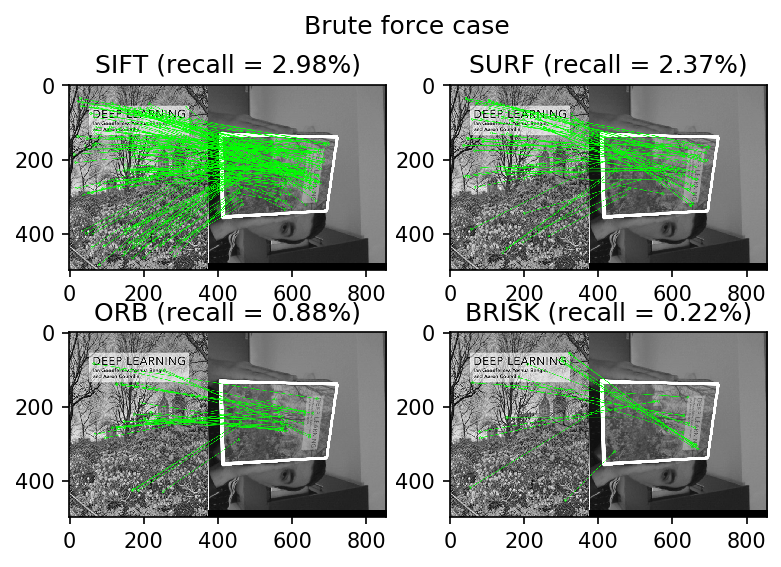

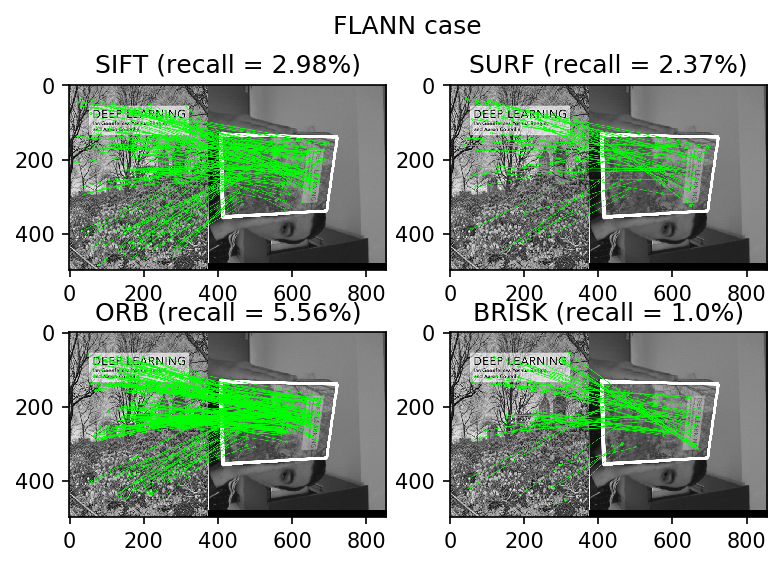

In [56]:
main()